## Save a datacube to your team storage
### A DeepESDL example notebook 

This notebook demonstrates how save a generated datacube to your team storage. In the example the CCI data store is used, for details concerning the CCI store are given in example notebook 02_Generate_CCI_cubes.ipynb

Please, also refer to the [DeepESDL documentation](https://deepesdl.readthedocs.io/en/latest/guide/jupyterlab/) and visit the platform's [website](https://www.earthsystemdatalab.net/) for further information!

Brockmann Consult, 2023

-----------------

**This notebook runs with the python environment `deepesdl-xcube-1.1.2`, please checkout the documentation for [help on changing the environment](https://deepesdl.readthedocs.io/en/latest/guide/jupyterlab/#python-environment-selection-of-the-jupyter-kerne).**


In [1]:
# mandatory imports
import os
from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store

# Utilities for notebook visualization
import shapely.geometry
from IPython.display import JSON
import matplotlib.pyplot as plt

Configure matplotlib to display graphs inline directly in the notebook and set a sensible default figure size.

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 16,8

Check whether the `cciodp` store is among the available stores, if not please follow the installation information from the top of this notebook. 

In [3]:
JSON({e.name: e.metadata for e in find_data_store_extensions()})

<IPython.core.display.JSON object>

Usually we need more information to get the actual data store object. Which data store parameters are available for `cciodp`? 

In [4]:
get_data_store_params_schema('cciodp')

Provide mandatory parameters to instantiate the store class:

In [5]:
store = new_data_store('cciodp')
store

Let's open an example dataset:

In [6]:
dataset = store.open_data('esacci.SST.day.L4.SSTdepth.multi-sensor.multi-platform.OSTIA.2-1.sst', 
                          variable_names=['analysed_sst'],
                          time_range=['2016-12-30','2016-12-31'])

dataset

<xarray.Dataset>
Dimensions:       (time: 2, lat: 3600, lon: 7200, bnds: 2)
Coordinates:
  * lat           (lat) float32 -89.97 -89.93 -89.88 ... 89.88 89.93 89.97
    lat_bnds      (lat, bnds) float32 dask.array<chunksize=(3600, 2), meta=np.ndarray>
  * lon           (lon) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
    lon_bnds      (lon, bnds) float32 dask.array<chunksize=(7200, 2), meta=np.ndarray>
  * time          (time) datetime64[ns] 2016-12-30T12:00:00 2016-12-31T12:00:00
    time_bnds     (time, bnds) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   esacci.SST.day.L4.SSTdepth.multi-sensor.multi-pl...
    date_created:            2023-07-03T09:58:23.465664
    processing_level:        L4
    time_coverage_start:     2016-12-30T00:00:00
    time_coverage_end:       2017-01-01T00:00:00
    time_coverage_duration:  P2DT0H0M0S
    history:                 [{'program': 'xcube_cci.chunkstore.CciChunkStore...

Plot one time stamp of the dataset for a analysed_sst in order to take a brief look at the dataset:  

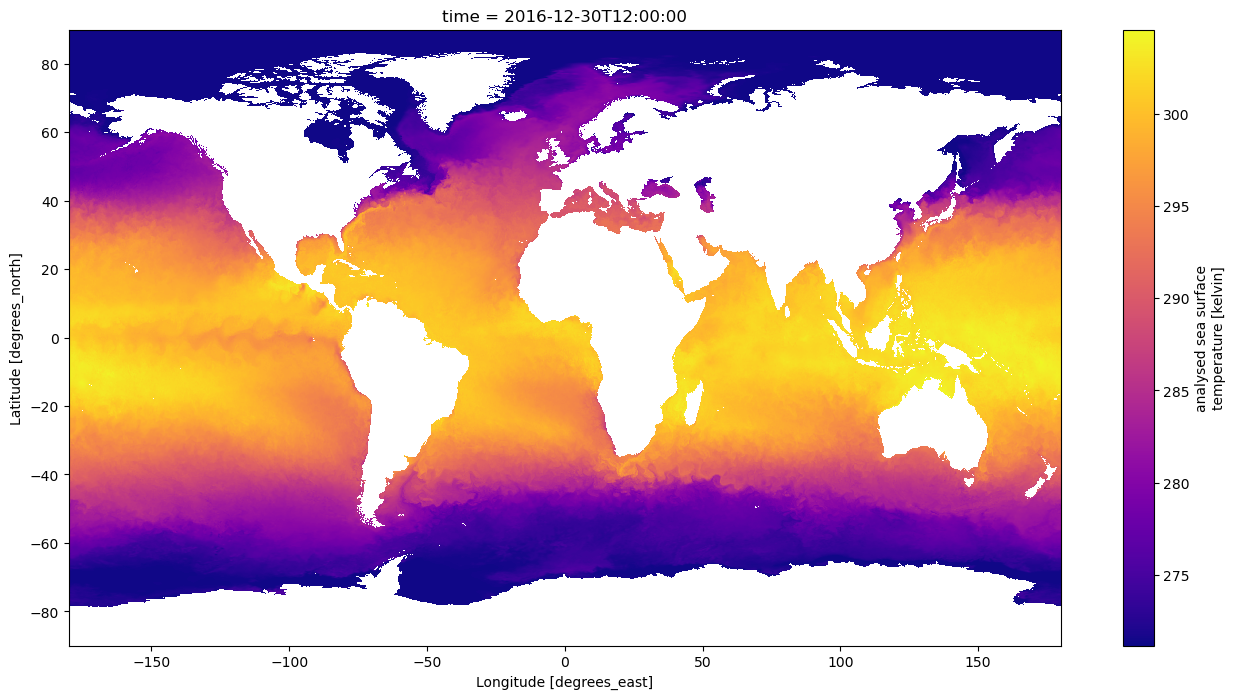

In [7]:
dataset.analysed_sst.isel(time=0).plot.imshow(cmap='plasma')

To store the cube in your teams user space, please first retrieve the details from your environment variables as the following:

In [8]:
S3_USER_STORAGE_KEY = os.environ["S3_USER_STORAGE_KEY"]
S3_USER_STORAGE_SECRET = os.environ["S3_USER_STORAGE_SECRET"]
S3_USER_STORAGE_BUCKET = os.environ["S3_USER_STORAGE_BUCKET"]

You need to instantiate a s3 datastore pointing to the team bucket:

In [9]:
from xcube.core.store import new_data_store
team_store = new_data_store("s3", 
                       root=S3_USER_STORAGE_BUCKET, 
                       storage_options=dict(anon=False, 
                                            key=S3_USER_STORAGE_KEY, 
                                            secret=S3_USER_STORAGE_SECRET))


If you have stored no data to your user space, the returned list will be empty:

In [11]:
list(team_store.get_data_ids())

[]

Save in levels format to generate data pyramid for efficient visualisation

In [12]:
team_store.write_data(dataset,'analysed_sst.levels', replace=True, use_saved_levels=True)

'analysed_sst.levels'

If you list the content of you datastore again, you will now see the newly written dataset in the list:

In [13]:
list(team_store.get_data_ids())

['analysed_sst.levels']

Open data from your team storage: 

In [14]:
ml_dataset = team_store.open_data( 'analysed_sst.levels')
ml_dataset

Check, how many levels were written:

In [15]:
ml_dataset.num_levels


3

Print metadata details for each multilevel dataset

In [16]:
for level in range(ml_dataset.num_levels):
    dataset_i = ml_dataset.get_dataset(level)
    display(dataset_i)

<xarray.Dataset>
Dimensions:       (time: 2, lat: 3600, lon: 7200, bnds: 2)
Coordinates:
  * lat           (lat) float32 -89.97 -89.93 -89.88 ... 89.88 89.93 89.97
    lat_bnds      (lat, bnds) float32 dask.array<chunksize=(3600, 2), meta=np.ndarray>
  * lon           (lon) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
    lon_bnds      (lon, bnds) float32 dask.array<chunksize=(7200, 2), meta=np.ndarray>
  * time          (time) datetime64[ns] 2016-12-30T12:00:00 2016-12-31T12:00:00
    time_bnds     (time, bnds) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    date_created:            2023-07-03T09:58:23.465664
    history:                 [{'cube_params': {'time_range': ['2016-12-30T00:...
    processing_level:        L4
    time_coverage_duration:  P2DT0H0M0S
    time_coverage_end:       2017-01-01T00:00:00
    time_coverage_start:     2016-12-30T00:00:00
    title:                   esacci.SST.day.L4.SSTdepth.multi-sensor.multi-pl...

<xarray.Dataset>
Dimensions:       (time: 2, lat: 1800, lon: 3600)
Coordinates:
  * lat           (lat) float32 -89.97 -89.88 -89.78 ... 89.72 89.82 89.93
  * lon           (lon) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * time          (time) datetime64[ns] 2016-12-30T12:00:00 2016-12-31T12:00:00
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    date_created:            2023-07-03T09:58:23.465664
    history:                 [{'cube_params': {'time_range': ['2016-12-30T00:...
    processing_level:        L4
    time_coverage_duration:  P2DT0H0M0S
    time_coverage_end:       2017-01-01T00:00:00
    time_coverage_start:     2016-12-30T00:00:00
    title:                   esacci.SST.day.L4.SSTdepth.multi-sensor.multi-pl...

<xarray.Dataset>
Dimensions:       (time: 2, lat: 900, lon: 1800)
Coordinates:
  * lat           (lat) float32 -89.97 -89.78 -89.57 ... 89.43 89.62 89.82
  * lon           (lon) float32 -180.0 -179.8 -179.6 ... 179.4 179.6 179.8
  * time          (time) datetime64[ns] 2016-12-30T12:00:00 2016-12-31T12:00:00
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(1, 900, 1800), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    date_created:            2023-07-03T09:58:23.465664
    history:                 [{'cube_params': {'time_range': ['2016-12-30T00:...
    processing_level:        L4
    time_coverage_duration:  P2DT0H0M0S
    time_coverage_end:       2017-01-01T00:00:00
    time_coverage_start:     2016-12-30T00:00:00
    title:                   esacci.SST.day.L4.SSTdepth.multi-sensor.multi-pl...

To work with a certain level:

In [17]:
dataset_2 = ml_dataset.get_dataset(2)


In [18]:
dataset_2

<xarray.Dataset>
Dimensions:       (time: 2, lat: 900, lon: 1800)
Coordinates:
  * lat           (lat) float32 -89.97 -89.78 -89.57 ... 89.43 89.62 89.82
  * lon           (lon) float32 -180.0 -179.8 -179.6 ... 179.4 179.6 179.8
  * time          (time) datetime64[ns] 2016-12-30T12:00:00 2016-12-31T12:00:00
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(1, 900, 1800), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    date_created:            2023-07-03T09:58:23.465664
    history:                 [{'cube_params': {'time_range': ['2016-12-30T00:...
    processing_level:        L4
    time_coverage_duration:  P2DT0H0M0S
    time_coverage_end:       2017-01-01T00:00:00
    time_coverage_start:     2016-12-30T00:00:00
    title:                   esacci.SST.day.L4.SSTdepth.multi-sensor.multi-pl...

To delete a dataset from your team user space:

In [19]:
team_store.delete_data('analysed_sst.levels')